In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import auc, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.externals.six import StringIO 
import graphviz
from IPython.display import Image
import pydotplus

pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
df3 = pd.read_csv('data/preprocessed_data.csv')
df3 = df3.drop(df3.columns[0], axis=1)
df3.head()

,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,insulin,glyburide-metformin,glipizide-metformin,metformin-rosiglitazone,metformin-pioglitazone,change,readmitted,service_utilization,num_diabetes_meds,change|num_medications,time_in_hospital|num_medications,num_medications|num_procedures,num_lab_procedures|time_in_hospital,num_medications|num_lab_procedures,num_medications|number_diagnoses,age|number_diagnoses,number_diagnoses|time_in_hospital,race_?,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,admission_type_1,admission_type_3,admission_type_4,admission_type_5,disch_dispo_1,disch_dispo_2,disch_dispo_7,disch_dispo_10,disch_dispo_18,disch_dispo_27,disch_dispo_28,admission_source_1,admission_source_2,admission_source_3,admission_source_4,admission_source_5,admission_source_6,admission_source_7,admission_source_8,admission_source_9,admission_source_10,admission_source_11,admission_source_13,admission_source_14,admission_source_17,admission_source_20,admission_source_22,admission_source_25,level1_diag_0.0,level1_diag_1.0,level1_diag_2.0,level1_diag_3.0,level1_diag_4.0,level1_diag_5.0,level1_diag_6.0,level1_diag_7.0,level1_diag_8.0,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_None,max_glu_serum_Norm,A1C_>7,A1C_>8,A1C_None,A1C_Norm
0,0,5,1,41,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,41,41,1,5,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0
1,0,15,3,59,0,18,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,18,54,0,177,1062,162,135,27,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,25,2,11,5,13,2,0,1,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,26,65,22,143,78,150,12,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,1,35,2,44,1,16,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,1,16,32,16,88,704,112,245,14,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,1,45,1,51,0,8,0,0,0,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,2,8,8,0,51,408,40,225,5,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0


In [3]:
# generate feature set and identify target variable
X = df3.loc[:, df3.columns != 'readmitted']
y = df3['readmitted']

#### Logistic Regression

In [4]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # using L1 as the penalty term - Lasso Regression will shrink less important features
# # Lasso is useful in this scenario becuase we have lot of features in our model

# logreg = LogisticRegression(penalty='l1')
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)

In [5]:
# print("Cross Validation Score: ", cross_val_score(logreg, X_train, y_train, cv=10))
# print("Accuracy: ", accuracy_score(y_test, y_pred))

In [6]:
# print("Confusion Matrix:")
# pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

In [7]:
# print(classification_report(y_test, y_pred))

In [8]:
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# auc_score = roc_auc_score(y_test, y_pred)

# print("Accuracy: ", accuracy)
# print("Precision: ", precision)
# print("Recall: ", recall)
# print("AUC: ", auc_score)

In [9]:
# fpr, tpr, threshold = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

In [10]:
# print('Original dataset shape {}'.format(Counter(y)))
# smt = SMOTE(random_state=42)
# X_new, y_new = smt.fit_sample(X, y)
# print('New dataset shape {}'.format(Counter(y_new)))

In [11]:
# X_new = pd.DataFrame(X_new, columns=X.columns)
# X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

# logreg = LogisticRegression(penalty='l1')
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)

In [12]:
# print("Cross Validation Score: ", cross_val_score(logreg, X_train, y_train, cv=10))
# print("Accuracy: ", accuracy_score(y_test, y_pred))

In [13]:
# print("Confusion Matrix:")
# pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

In [14]:
# print(classification_report(y_test, y_pred))

In [15]:
# accuracy = accuracy_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)
# auc_score = roc_auc_score(y_test, y_pred)

# print("Accuracy: ", accuracy)
# print("Precision: ", precision)
# print("Recall: ", recall)
# print("AUC: ", auc_score)

In [16]:
# fpr, tpr, threshold = roc_curve(y_test, y_pred)
# roc_auc = auc(fpr, tpr)

# plt.title('Receiver Operating Characteristic')
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()

#### Decision Tree Classification

In [17]:
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=42)
X_new, y_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(y_new)))

Original dataset shape Counter({0: 64139, 1: 6296})
New dataset shape Counter({0: 64139, 1: 64139})


In [18]:
X_new = pd.DataFrame(X_new, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

dtree = DecisionTreeClassifier(max_depth=25, criterion = 'entropy', min_samples_split=10)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

In [19]:
print("Cross Validation Score: ", cross_val_score(dtree, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross Validation Score:  [0.90368556 0.90312883 0.90477781 0.90199354 0.90299588 0.91190556
 0.90433233 0.90310725 0.90655975 0.9094554 ]
Accuracy:  0.9065585697952396


In [20]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,17606,1791,19397
1,1805,17282,19087
All,19411,19073,38484


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     19397
           1       0.91      0.91      0.91     19087

   micro avg       0.91      0.91      0.91     38484
   macro avg       0.91      0.91      0.91     38484
weighted avg       0.91      0.91      0.91     38484



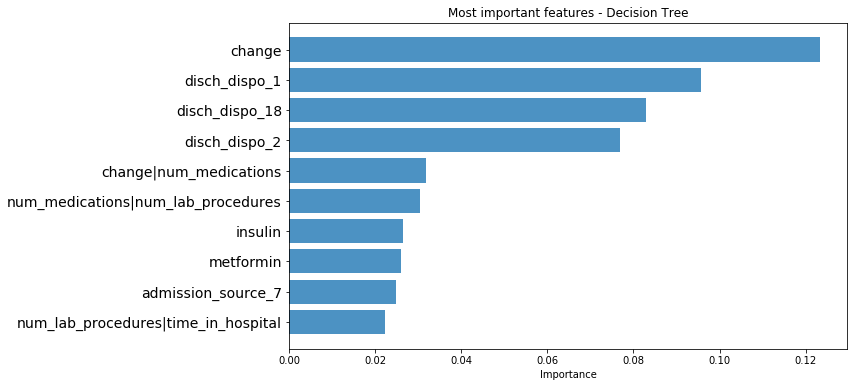

In [43]:
# Create list of most important features
feature_names = X_train.columns
feature_imports = dtree.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Decision Tree')
plt.show()

In [24]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("AUC: ", auc_score)

Accuracy:  0.9065585697952396
Precision:  0.9060976249148011
Recall:  0.9054330172368628
AUC:  0.9065495755875503


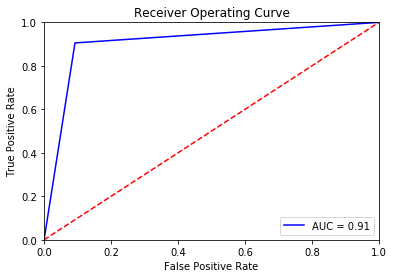

In [25]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [26]:
# dot_dt_q2 = tree.export_graphviz(dtree, out_file="dt_q2.dot", feature_names=X_train.columns, max_depth=2, 
#                                  class_names=["No","Readm"], filled=True, rounded=True, special_characters=True)
# graph_dt_q2 = pydotplus.graph_from_dot_file('dt_q2.dot')
# Image(graph_dt_q2.create_png())

In [27]:
# dot_data = StringIO()
# export_graphviz(dtree, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())

#### Random Forest Classification

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = 'gini', min_samples_split=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [29]:
print("Cross Validation Score: ", cross_val_score(clf, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross Validation Score:  [0.90957015 0.90995741 0.91076861 0.91054767 0.91054767 0.91115619
 0.91014199 0.91075051 0.91034483 0.91135903]
Accuracy:  0.9091382329279258


In [30]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,5678,6,5684
1,605,0,605
All,6283,6,6289


In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     19226
           1       0.06      0.00      0.00      1905

   micro avg       0.91      0.91      0.91     21131
   macro avg       0.48      0.50      0.48     21131
weighted avg       0.83      0.91      0.87     21131



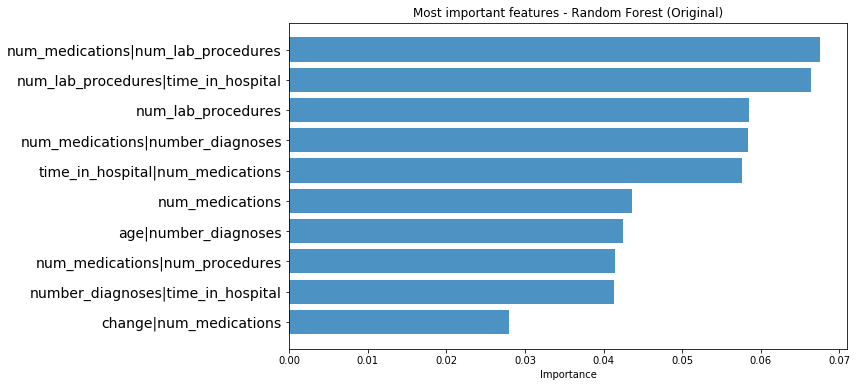

In [32]:
# Create list of most important features
feature_names = X_train.columns
feature_imports = clf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (Original)')
plt.show()

In [33]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("AUC: ", auc_score)

Accuracy:  0.9091382329279258
Precision:  0.058823529411764705
Recall:  0.0005249343832020997
AUC:  0.499846363998009


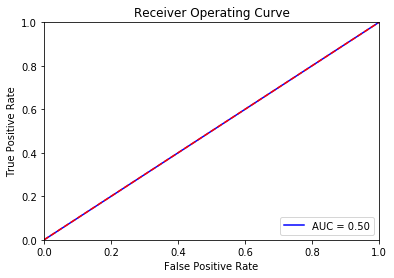

In [34]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [35]:
print('Original dataset shape {}'.format(Counter(y)))
smt = SMOTE(random_state=42)
X_new, y_new = smt.fit_sample(X, y)
print('New dataset shape {}'.format(Counter(y_new)))

Original dataset shape Counter({0: 64139, 1: 6296})
New dataset shape Counter({0: 64139, 1: 64139})


In [36]:
X_new = pd.DataFrame(X_new, columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators = 10, max_depth=25, criterion = 'gini', min_samples_split=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [37]:
print("Cross Validation Score: ", cross_val_score(clf, X_train, y_train, cv=10))
print("Accuracy: ", accuracy_score(y_test, y_pred))

Cross Validation Score:  [0.94098653 0.93686672 0.93785499 0.93262056 0.94164161 0.94375766
 0.93841185 0.93785499 0.94075064 0.94253258]
Accuracy:  0.9424176281051866


In [38]:
print("Confusion Matrix:")
pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_pred, name = 'Predict'), margins = True)

Confusion Matrix:


Predict,0,1,All
Actual,,,
0,19225,172,19397
1,2044,17043,19087
All,21269,17215,38484


In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.95     19397
           1       0.99      0.89      0.94     19087

   micro avg       0.94      0.94      0.94     38484
   macro avg       0.95      0.94      0.94     38484
weighted avg       0.95      0.94      0.94     38484



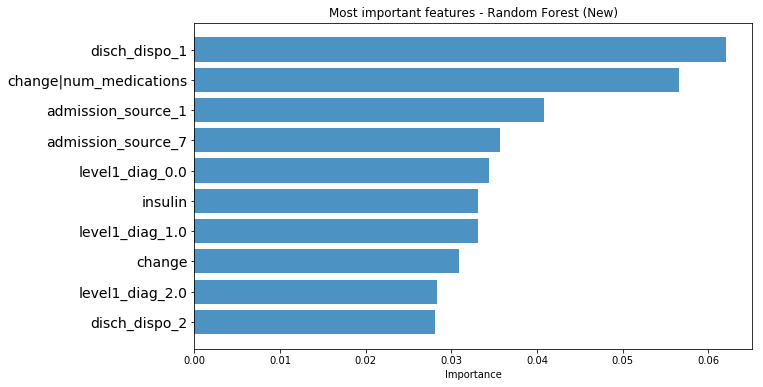

In [40]:
# Create list of most important features
feature_names = X_train.columns
feature_imports = clf.feature_importances_
most_imp_features = pd.DataFrame([f for f in zip(feature_names,feature_imports)], columns=["Feature", "Importance"]).nlargest(10, "Importance")
most_imp_features.sort_values(by="Importance", inplace=True)
plt.figure(figsize=(10,6))
plt.barh(range(len(most_imp_features)), most_imp_features.Importance, align='center', alpha=0.8)
plt.yticks(range(len(most_imp_features)), most_imp_features.Feature, fontsize=14)
plt.xlabel('Importance')
plt.title('Most important features - Random Forest (New)')
plt.show()

In [41]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("AUC: ", auc_score)

Accuracy:  0.9424176281051866
Precision:  0.9900087133313971
Recall:  0.8929114056687798
AUC:  0.9420220275237748


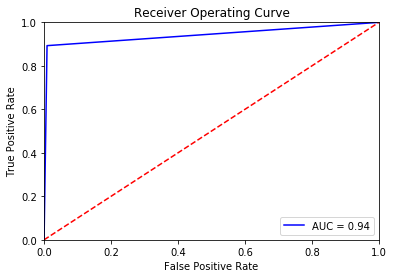

In [42]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()